<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>
<h4>Students:
    <lu>
        <li>Tristan NEMOZ</li>
        <li>Thomas GENTILHOMME</li>
    </lu>
</h4>

The first AML challenge for this year is adapted from the well-known '<i>Zillow's Home Value Prediction</i>' competition on Kaggle.
In particular, given a dataset containing descriptions of homes on the US property market, your task is to make predictions on the selling price of as-yet unlisted properties. 
Developing a model which accurately fits the available training data while also generalising to unseen data-points is a multi-faceted challenge that involves a mixture of data exploration, pre-processing, model selection, and performance evaluation.

# Overview
<hr style="height:1px;border:none;color:#333;background-color:#333;" />    

Beyond simply producing a well-performing model for making predictions, in this challenge we would like you to start developing your skills as a machine learning scientist.
In this regard, your notebook should be structured in such a way as to explore the five following tasks that are expected to be carried out whenever undertaking such a project.
The description below each aspect should serve as a guide for your work, but you are strongly encouraged to also explore alternative options and directions. 
Thinking outside the box will always be rewarded in these challenges.

<div class="alert alert-block alert-success">
Let's import useful libraries and install the useful ones.
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from time import time
import sys
import seaborn as sns

from IPython.display import display

In [3]:
!pip3 install --user --upgrade pip
!pip3 install 'scikit-learn' --user --upgrade

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Requirement already up-to-date: pip in /mnt/workspace/.local/lib/python3.5/site-packages (20.1.1)
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Requirement already up-to-date: scikit-learn in /mnt/workspace/.local/lib/python3.5/site-packages (0.22.2.post1)


<div class="">
    <h3>1. Data Exploration</h3>
</div>

The first broad component of your notebook should enable you to familiarise yourselves with the given data, an outline of which is given at the end of this challenge specification.
Among others, this section should investigate:

- Data cleaning, e.g. treatment of categorical variables;
- Data visualisation;
- Computing descriptive statistics, e.g. correlation.
- etc.

<div class="alert alert-block alert-success">
In this cell, we start by cleaning all the training and testing data.  <br>
Then, we separate the training data into 3 different types:
<ul>
    <li><b>Numerical data:</b> we don't touch them.</li>
    <li><b>Categorical data</b> that <b>can be ordered</b> (see "associations" below): we replace each value of these attributes by a number that translate this order (ex: $0$ for NA, $1$ for Poor,$\ldots$ ,$5$ for Excellent). The point of attributing arbitrary values is that we hope that our model will adapt themselves to know how to properly consider such a value.</li>
    <li><b>Categorical data</b> that <b>can NOT be ordered</b> (see "categorical" below): we replace each of these columns by columns corresponding to their values, by aplying the $get\_dummies$ function.</li>
</ul>
</div>

In [6]:
from time import time

base = "challenge_data/"

# Reading data
train_data = pd.read_csv(base + "train.csv")
test_data = pd.read_csv(base + "test.csv")

# Defining categorical data
categorical = [
    'MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType' ,'SaleCondition'
]

# Defining the mapping for categorical ordered data
associations = {}
associations['LotShape'] = ['Reg', 'IR1', 'IR2', 'IR3']
associations['LandContour'] = ['Low', 'HLS', 'Bnk', 'Lvl']
associations['Utilities'] = ['ELO', 'NoSeWa', 'NoSewr', 'AllPub']
associations['LandSlope'] = ['Sev', 'Mod', 'Gtl']
associations['LotShape'] = ['Reg', 'IR1', 'IR2', 'IR3']
associations['HouseStyle'] = ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin', '2.5Unf', 'SFoyer', 'SLvl']
associations['ExterQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['ExterCond'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['BsmtQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['BsmtCond'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['BsmtExposure'] = ['No', 'Mn', 'Av', 'Gd']
associations['BsmtFinType1'] = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
associations['BsmtFinType2'] = ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
associations['HeatingQC'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['CentralAir'] = ['N', 'Y']
associations['KitchenQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['Functional'] = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
associations['FireplaceQu'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['GarageFinish'] = ['Unf', 'RFn', 'Fin']
associations['GarageQual'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['GarageCond'] = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
associations['PavedDrive'] = ['N', 'P', 'Y']
associations['PoolQC'] = ['Fa', 'TA', 'Gd', 'Ex']
associations['Fence'] = ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']

def format_series(associations):
    """ Formats the series mapped to their ordered valued thanks to associations.
    
    :param associations: The mapping between a series name and its ordered values.
    :type associations: tuple
    """
    
    for series in associations:
        for i in range(len(associations[series])):
            train_data[series].fillna(0, inplace=True)
            train_data[series].replace(associations[series][i], i + 1, inplace=True)
            test_data[series].fillna(0, inplace=True)
            test_data[series].replace(associations[series][i], i + 1, inplace=True)


def get_dummies_from_categorical(categorical, train=True):
    """ Returns a column for each value in a non-ordered categorical data. It takes into account duplicate names values.
    
    :param categorical: A list containing the names of the non-ordered categorical series we want to replace.
    :type categorical: list
    """
    if train:
        result = train_data.copy(deep=True)
        new_cols = []

        for series in categorical:
            dummies = pd.get_dummies(train_data[series])
            for cols in dummies.columns:  # Allows to rename duplicates columns
                for i, els in enumerate(new_cols):
                    if els[0] == cols :
                        n = new_cols[i][1]
                        dummies.rename(columns={cols: cols+str(n+1)}, inplace=True)
                        new_cols[i][1] = n + 1
                        break

                new_cols.append([cols,0])

            result = pd.concat([result, dummies], sort=False, axis=1)
            result.drop(series, axis=1, inplace=True)

        new_cols[:] = []

        return result
    
    result = test_data.copy(deep=True)
    new_cols = []

    for cols in result.columns:
        test_dataDF[cols] = test_data[cols]
    train_cols = train_data.columns
    for series in categorical:
        dummies = pd.get_dummies(test_data[series])
        for cols in dummies.columns:  # Allows to rename duplicates columns
            for i, els in enumerate(new_cols):
                if els[0] == cols :
                    n = new_cols[i][1]
                    dummies.rename(columns={cols: cols+str(n+1)}, inplace=True)
                    new_cols[i][1] = n + 1
                    break
        
            new_cols.append([cols,0])
        
        for cols in dummies.columns:
            if cols in test_dataDF.columns:
                test_dataDF[cols] = dummies[cols]

            
    for cols in test_dataDF.columns:
        if cols not in train_cols:
            test_dataDF.drop(cols, axis=1, inplace=True)
    test_dataDF.fillna(0, inplace=True)
    
    new_cols[:] = []

    return test_dataDF

def denormalized_results(scaler, train_data, predict_prices):
    """ Applies the inverse transformation to work with real-world values rather than standardized ones.
    
    :param scaler: The scaler used to standardize the data.
    :param train_data: The former standardized data.
    :param predict_prices: The data on which we want to apply the ivnerse transformation.
    :type scaler: tuple
    :type train_data: pd.DataFrame
    :type predict_prices: np.array
    """
    
    std_sp = scaler[scaler['Name'] == 'SalePrice']['Std'].values[0]
    mean_sp = scaler[scaler['Name'] == 'SalePrice']['Mean'].values[0]
    predict_prices = (predict_prices * std_sp) + mean_sp

    std_id = scaler[scaler['Name'] == 'Id']['Std'].values[0]
    mean_id = scaler[scaler['Name'] == 'Id']['Mean'].values[0]
    ids = np.floor((train_data['Id'].values * std_id) + mean_id + 0.5)
    
    prices = pd.DataFrame({'Id': ids, 'SalePrice': predict_prices})
    
    return prices

def return_results_as_csv(data_results, model_name=''):
    data_results.to_csv('test_data_submission_' + model_name + '.csv', index=False)


def plot_absolute_difference(y, y_pred):
    """ Plots an histogram representing the absolute differences between a model predictions and its targets.
    
    :param y: The targets the model tries to reach.
    :param y_pred: The predictions of the model.
    :type y: np.array
    :type y_pred: np.array
    """
    
    differences = np.abs(y - y_pred)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(differences, bins=50, density=True)
    ax.set_xlabel('Absolute Difference')
    ax.axvline(np.mean(differences), label='Mean (%.2f)' % np.mean(differences), color='r')
    ax.axvline(np.median(differences), label='Median (%.2f)' % np.median(differences), color='g')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.grid()
    plt.show()

def time_model(model, data, data_labels):
    """ Plots a graph showing the time taking to train the model and make a prediction with it 
    in function of the size of the datasets we are training it with.
    
    :param model: The model we want to time
    :param data: Examples data to train the model on
    :param data_labels: Examples data labels to train the model on
    :type data: pd.DataFrame
    :type data_labels: pd.DataFrame
    """
    x = np.arange(0, data.shape[0], 25)
    t = np.zeros(x.shape)
    
    for i, j in enumerate(x):
        start = time()
        model.fit(data[:j + 1], data_labels[:j + 1])
        model.predict(data.iloc[:j + 1])
        t[i] = time() - start
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.set_ylabel('Execution time (s)')
    ax.set_xlabel('Dataset size')
    plt.grid()
    ax.plot(x, t)
    plt.show()

format_series(associations)
train_data = get_dummies_from_categorical(categorical)
test_dataDF = pd.DataFrame(columns=train_data.columns)
test_data = get_dummies_from_categorical(categorical, train=False)
display(train_data[:10])
display(test_data[:10])

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,HouseStyle,OverallQual,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,1,60,65.0,8450,1,4,4,3,4,7,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,1,4,4,3,1,6,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,2,4,4,3,4,7,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,2,4,4,3,4,7,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,2,4,4,3,4,8,...,0,0,0,1,0,0,0,0,1,0
5,6,50,85.0,14115,2,4,4,3,2,5,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,1,4,4,3,1,8,...,0,0,0,1,0,0,0,0,1,0
7,8,60,NaN,10382,2,4,4,3,4,7,...,0,0,0,1,0,0,0,0,1,0
8,9,50,51.0,6120,1,4,4,3,2,7,...,0,0,0,1,1,0,0,0,0,0
9,10,190,50.0,7420,1,4,4,3,3,5,...,0,0,0,1,0,0,0,0,1,0


,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,HouseStyle,OverallQual,...,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
0,1201,20,71.0,9353,1,4,4,3,1,4,...,0,0,1,0,1,0,0,0,0,0
1,1202,60,80.0,10400,1,4,4,3,4,7,...,0,0,0,1,0,0,0,0,1,0
2,1203,50,50.0,6000,1,4,4,3,2,5,...,0,0,0,1,0,0,0,0,1,0
3,1204,20,75.0,9750,1,4,4,3,1,7,...,0,0,0,1,0,0,0,0,1,0
4,1205,20,78.0,10140,1,4,4,3,1,5,...,0,0,0,1,0,0,0,0,1,0
5,1206,20,90.0,14684,2,4,4,3,1,7,...,0,0,0,1,0,0,0,0,1,0
6,1207,20,0.0,8900,1,4,4,3,1,4,...,0,0,0,1,0,0,0,0,1,0
7,1208,20,70.0,9135,1,4,4,3,1,6,...,0,0,0,1,0,0,0,0,1,0
8,1209,20,70.0,7763,1,4,4,3,1,5,...,0,0,0,1,0,0,0,0,1,0
9,1210,20,85.0,10182,2,4,4,3,1,8,...,0,1,0,0,0,0,0,0,0,1


<div class="alert alert-block alert-success">
We observe that we have some $NaN$ in the numerical columns. We might think that we could just delete the correspond values, but we observe that its corresponds to almost a quarter of all the values, and we don't have so much. Instead, another method could be to simply delete the corresponding attributes.
<br>
Let see how many columns have $NaNs$:
</div>

In [3]:
# Checking which series have NaNs
series_check = train_data.isna().any()
series_check[series_check == True]

LotFrontage    True
MasVnrArea     True
GarageYrBlt    True
dtype: bool

<div class="alert alert-block alert-success">
    We observe that <i>only</i> 3 columns, over 204, have $NaNs$. Let observe their correlation with $SalePrice$ to see whether deleting them is possible.
</div>

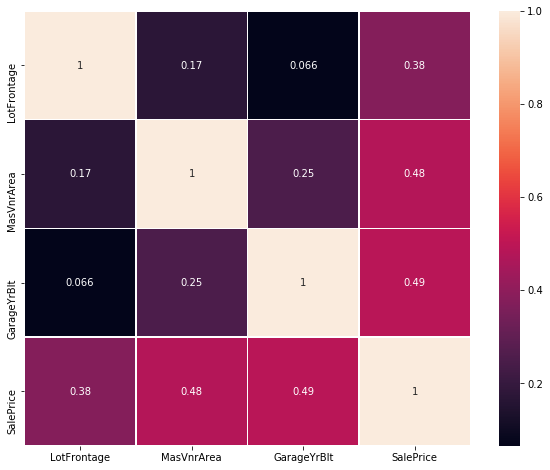

In [5]:
# Calculating correlations for suspected series
corr_df = pd.DataFrame()
corr_df['LotFrontage'] = train_data['LotFrontage'].copy(deep=True)
corr_df['MasVnrArea'] = train_data['MasVnrArea'].copy(deep=True)
corr_df['GarageYrBlt'] = train_data['GarageYrBlt'].copy(deep=True)
corr_df['SalePrice'] = train_data['SalePrice'].copy(deep=True)

corr = corr_df.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True, linewidth=.5, ax=ax)

<div class="alert alert-block alert-success">
As we can see above, those colums don't have a negligible correlation with SalePrice (from $0.38$ to $0.48$). Simply deleting them might not be a good idea either. We will discuss that in the next part.
</div>

<div class="alert alert-block alert-success">
Below, we draw some interesting plots to have more information and a better knowledge of our data, and how they are correlated.
<br><br>
Fist, we display the ECDF plot of SalePrice to have an idea of how the are distributed. Then, we display a correlation heatmap of the most correlated columns (those which have more than 65% of correlation with SalePrice) and finally we draw their Violin Plots to highlight some interesting correlations.
</div>

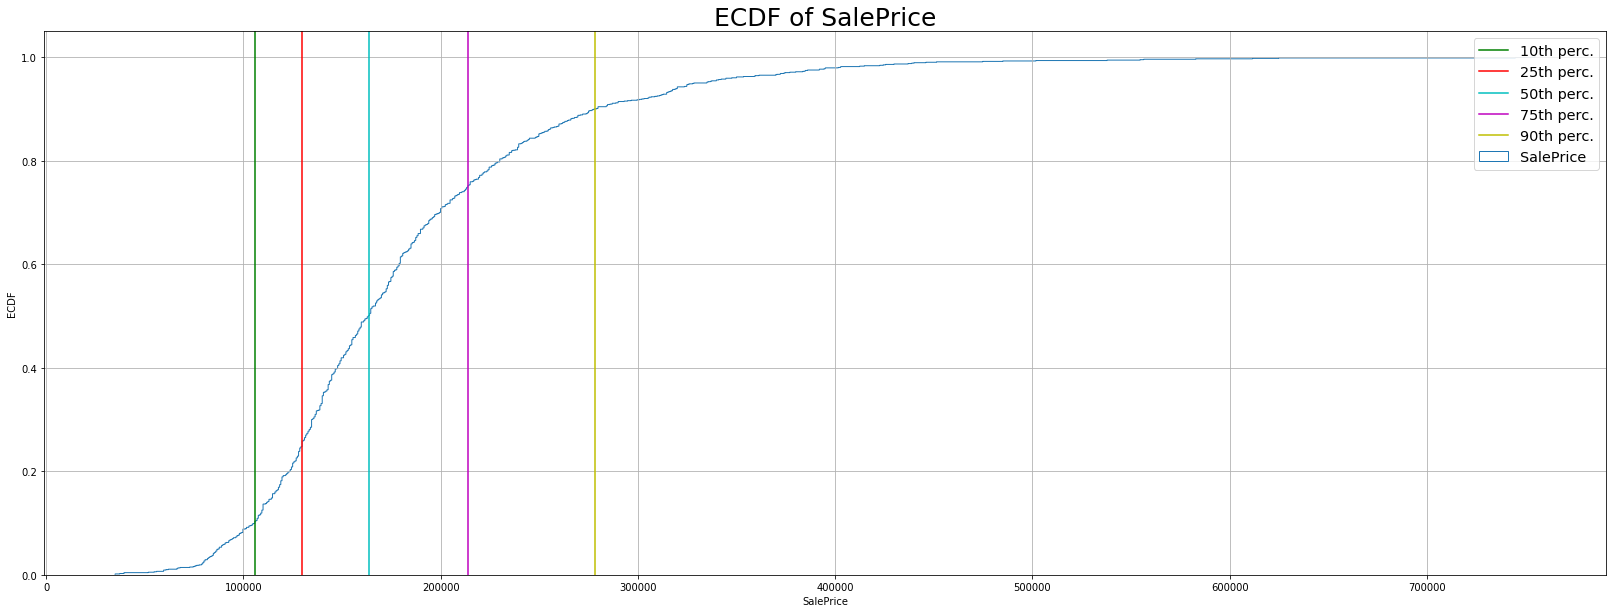

In [26]:
COLORS = 'grcmykwb'

def fix_ending_line(ax):
    """ Removes the final vertical line when plotting an histogram.
    
    :param ax: The Axes object used for plotting the histogram.
    """
    
    axpolygons = [poly for poly in ax.get_children() if isinstance(poly, matplotlib.patches.Polygon)]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])

def plot_ecdf(series, bins=0, title=None, x_label=None):
    """ Plots the Estimated Cumulative Distribution Function for a given series.
    
    :param series: The Series object for which we want to plot the ECDF.
    :param bins: The number of bins to be used for plotting the histogram.
    :param title: The title of the figure to be printed.
    :param x_label: The label of the x-axis of the figure.
    """
    
    fig, ax = plt.subplots(figsize=(28, 10))

    # Plot the cumulative distribution
    bins = series.shape[0] if not bins else bins
    series.plot.hist(cumulative=True, histtype='step', bins=bins, density=True)

    # Calculate and plot the 5 important percentiles
    for i, quantile in enumerate([.1, 0.25, .5, .75, .9]):
        ax.axvline(series.quantile(quantile), label='%.0fth perc.' % (quantile*100), color=COLORS[i])
    
    if title:
        ax.set_title(title, fontsize=25)
    else:
        ax.set_title('ECDF of ' + series.name, fontsize=25)
    
    if x_label:
        ax.set_xlabel(x_label)
    else:
        ax.set_xlabel(series.name)
    
    ax.set_ylabel('ECDF')
    ax.legend(loc='lower right', fontsize='x-large')
    fix_ending_line(ax)
    plt.grid()
    plt.show()

plot_ecdf(train_data['SalePrice'])

<div class="alert alert-block alert-success">
    We can see that there is only few extremal values in the dataset. Indeed, all the percentiles of the graph are quite close. Thus, extremal values may be considered as outliers later.
</div>

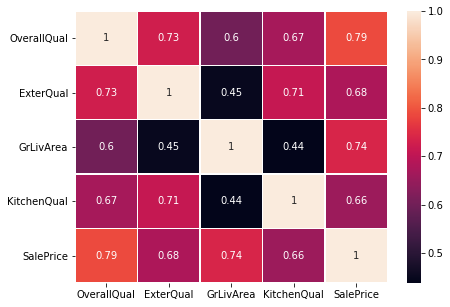

In [7]:
plot_data = train_data.copy(deep=True)

for names in list(plot_data)[:]:
    corr = plot_data['SalePrice'].corr(plot_data[names])
    if np.abs(corr) < 0.65:
        plot_data.drop([names],axis=1,inplace=True)
corr = plot_data.corr()
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(corr, annot=True, linewidth=.5, ax=ax)

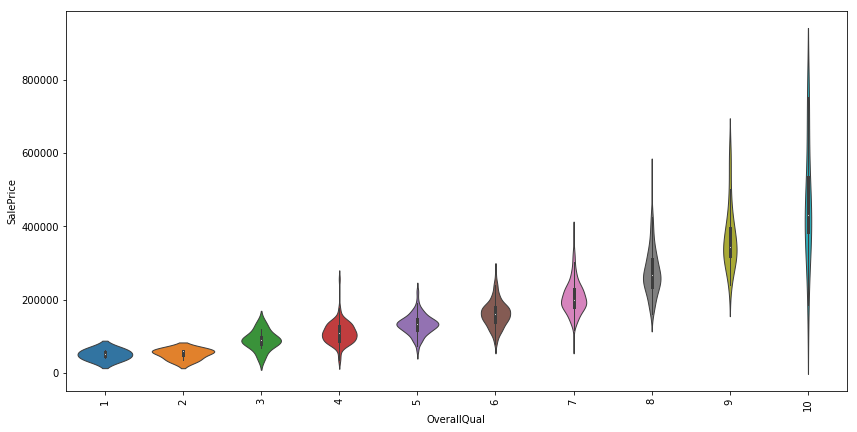

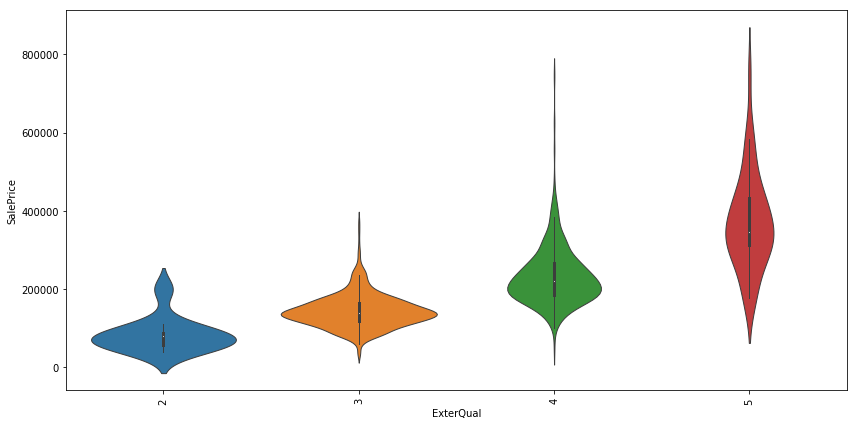

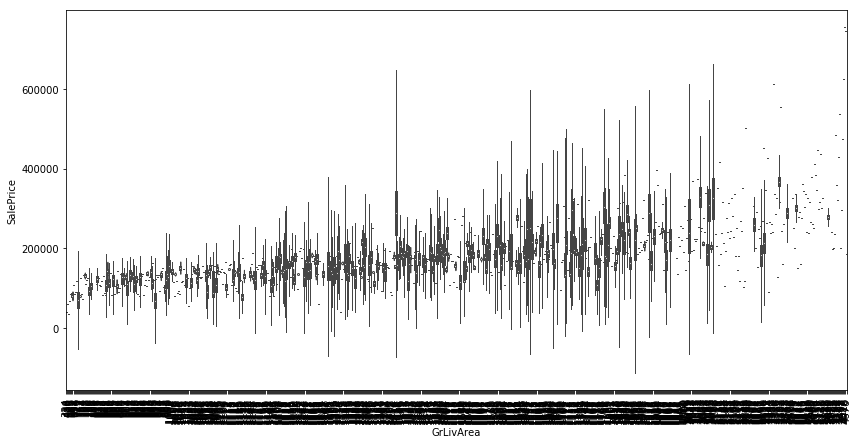

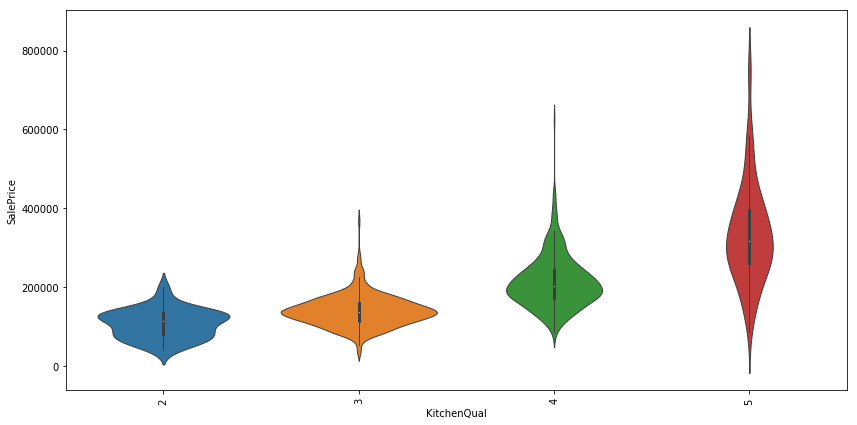

In [8]:
for name in plot_data.columns[:-1]:
    ax = plt.subplots(figsize=(14, 7))
    plt.xticks(rotation='vertical')
    ax=sns.violinplot(x=name, y="SalePrice", data=plot_data, linewidth=1)
    plt.show()

<div class="alert alert-block alert-success">
    The violin plots are quite useful, because not only they show us the range of values for each of the data we consider, but also how it is distributed with the width of the violin. Thus, a model may work by trying to link the most wide parts of the violin plots for instance. In any case, it shows us a possible relation between a single-dimension value and the single-dimensioned value we consider, SalePrice.
</div>

<div class="">
    <h3>2. Data Pre-processing</h3>
</div>

The previous step should give you a better understanding of which pre-processing is required for the data.
This may include:

- Normalising and standardising the given data;
- Removing outliers;
- Carrying out feature selection, possibly using metrics derived from information theory;
- Handling missing information in the dataset;
- Augmenting the dataset with external information;
- Combining existing features.

<div class="alert alert-block alert-success">
First of all, we separate the dataset into a training one and a validation one.
</div>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

train_dataDF, validation_dataDF = train_test_split(train_data, test_size=0.15, random_state=1)

<div class="alert alert-block alert-success">
    <h4>Handling missing information in the dataset</h4>
    <br>
    As we have seen in the previous part: there is 2 ways to handle missing elements:
    <ul>
        <li>Either we delete the corresponding values: this is the easiest solution but the problem is that its deletes about a quarter of all the dataset, which is already not so big (only 1200 values).</li>
        <li>Or we delete the corresponfing columns, in order to overpass this problem. The advantage is that its only 3 columns but the problem is, as we have previously shown, that these colums are not low correlated with <i>SalePrice</i>.</li>
    </ul>
As a solution, we will build 2 models based on these two ways to handle missing elements. Here are our 2 different datasets:
</div>

In [8]:
# Defining the two models which come from the two ways we have to get rid of NaNs
train_data_nrows = train_dataDF.dropna()
validation_data_nrows = validation_dataDF.dropna()

train_data_ncols = train_dataDF.dropna(axis=1)
validation_data_ncols = validation_dataDF.dropna(axis=1)

test_data_nrows = test_data.dropna()
test_data_ncols = test_data.dropna(axis=1)

<div class="alert alert-block alert-success">
 <h4>Dealing with outliers</h4>
    What we want to do next is to remove the outliers. According to <a href="https://scikit-learn.org/stable/modules/outlier_detection.html"> the sklearn documentation about it</a>, IsolationForests perform well on this task. Thus, this is the one we are going to use here to both detect and remove the outliers.
</div>

In [9]:
from sklearn.ensemble import IsolationForest

# Defining the model
isolation_forest_nrows = IsolationForest(
    contamination=0.1,  # We consider 10% of the dataset as outliers
    behaviour='new',
)
isolation_forest_ncols = IsolationForest(
    contamination=0.1,  # We consider 10% of the dataset as outliers
    behaviour='new',
)

# Training the model
isolation_forest_nrows.fit(train_data_nrows)
isolation_forest_ncols.fit(train_data_ncols)

# Removing outliers
ncols_outliers_predict = isolation_forest_ncols.predict(train_data_ncols)
train_data_ncols = train_data_ncols[ncols_outliers_predict == 1]

nrows_outliers_predict = isolation_forest_nrows.predict(train_data_nrows)
train_data_nrows = train_data_nrows[nrows_outliers_predict == 1]

/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning
/mnt/workspace/.local/lib/python3.5/site-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


<div class="alert alert-block alert-success">
    <h4>Normalising and standardising the given data</h4>
    In this part, we center all the data around <b>0</b> and we divide them by the corresponding <b>standard deviation</b>. We save the results in a DataFrame in order to apply the inverse transformation later. We also have to take care to apply the same transformations to both the validation and the test dataset as the one we applied on the training dataset.
</div>

In [12]:
import warnings

warnings.filterwarnings("ignore")

scaler_rows = pd.DataFrame(columns=['Name', 'Mean', 'Std'])
scaler_cols = pd.DataFrame(columns=['Name', 'Mean', 'Std'])

# Normalising the data
for column in train_data_nrows.columns:
    mean = train_data_nrows[column].mean()
    std = train_data_nrows[column].std()
    to_scaler = {
        'Name': column,
        'Mean': mean,
        'Std': std
    }
    scaler_rows = scaler_rows.append(to_scaler, ignore_index=True)
    train_data_nrows[column] = (train_data_nrows[column] - mean) / std if std else train_data_nrows[column] - mean
    validation_data_nrows[column] = (validation_data_nrows[column] - mean) / std if std else validation_data_nrows[column] - mean
    
    if column != "SalePrice":
        test_data_nrows[column] = (test_data_nrows[column] - mean) / std if std else test_data_nrows[column] - mean
    
# Normalising the data
for column in train_data_ncols.columns:
    mean = train_data_ncols[column].mean()
    std = train_data_ncols[column].std()
    to_scaler = {
        'Name': column,
        'Mean': mean,
        'Std': std
    }
    scaler_cols = scaler_cols.append(to_scaler, ignore_index=True)
    train_data_ncols[column] = (train_data_ncols[column] - mean) / std if std else train_data_ncols[column] - mean
    validation_data_ncols[column] = (validation_data_ncols[column] - mean) / std if std else validation_data_ncols[column] - mean
    
    if column != "SalePrice":
        test_data_ncols[column] = (test_data_ncols[column] - mean) / std if std else test_data_ncols[column] - mean

# Defining our training and validation sets
train_data_nrows_labels = train_data_nrows['SalePrice'].values
train_data_nrows_features = train_data_nrows.drop(['SalePrice'], axis=1)
validation_data_nrows_labels = validation_data_nrows['SalePrice'].values
validation_data_nrows_features = validation_data_nrows.drop(['SalePrice'], axis=1)

train_data_ncols_labels = train_data_ncols['SalePrice'].values
train_data_ncols_features = train_data_ncols.drop(['SalePrice'], axis=1)
validation_data_ncols_labels = validation_data_ncols['SalePrice'].values
validation_data_ncols_features = validation_data_ncols.drop(['SalePrice'], axis=1)

test_data_nrows_labels = test_data_nrows['SalePrice'].values
test_data_nrows_features = test_data_nrows.drop(['SalePrice'], axis=1)
test_data_ncols_labels = test_data_ncols['SalePrice'].values
test_data_ncols_features = test_data_ncols.drop(['SalePrice'], axis=1)

<div class="">
    <h3>3. Model Selection</h3>
</div>

Perhaps the most important segment of this challenge involves the selection of a model that can successfully handle the given data and yield sensible predictions.
Instead of focusing exclusively on your final chosen model, it is also important to share your thought process in this notebook by additionally describing alternative candidate models.
There is a wealth of models to choose from, such as <i>decision trees</i>, <i>random forests</i>, <i>(Bayesian) neural networks</i>, <i>Gaussian processes</i>, <i>LASSO regression</i>, and so on.
There are several factors which may influence your decision:

- What is the model's complexity?
- Is the model interpretable?
- Is the model capable of handling different data-types?
- Does the model return uncertainty estimates along with predictions?

An in-depth evaluation of competing models in view of this and other criteria will elevate the quality of your submission and earn you a higher grade.


In [15]:
def mse(scaler, y, y_pred):
    """ Calculate the Mean Squared Error of the logarithms.
    
    :param scaler: The scaler used to normalize data.
    :param y: The labels we want to predict.
    :param y_pred: The prediction made by the model.
    :type scaler: DataFrame
    :type y: np.array
    :type y_pred: np.array
    """
    
    std = scaler[scaler['Name'] == 'SalePrice']['Std'].values[0]
    mean = scaler[scaler['Name'] == 'SalePrice']['Mean'].values[0]
    y_pred = (y_pred * std) + mean
    y = (y * std) + mean
    
    return np.mean((np.log(y)-np.log(y_pred)) ** 2)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import ParameterSampler, ParameterGrid
import scipy

<div class="alert alert-block alert-success">
    <h3>Model 1 - Random Forests</h3>
</div>

<div class="alert alert-block alert-success">
    First of all, we can try random forests as a model for our data. The main interest of random forests is to avoid overfitting by creating a lot of estimators. Thus, we think it is worth a try to build such a model.
</div>

In [17]:
# Defining hyperparameters possible values
hyperparameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [10, 20, 30, 50, 70, 100, 300, 500]
}

parameter_grid = list(ParameterGrid(hyperparameters))
resultsDF_rows = pd.DataFrame(columns=['n_estimators', 'max_depth', 'loss'])
resultsDF_cols = pd.DataFrame(columns=['n_estimators', 'max_depth', 'loss'])

verbose = False
i = 1

starting_time = time()
last_printed = 0

# Finding loss values for thoses hyperparameters
for parameter_combination in parameter_grid:
    # Defining the models
    RFRrows = RandomForestRegressor(
        n_estimators=parameter_combination['n_estimators'],
        max_depth=parameter_combination['max_depth'],
        n_jobs=9
    )
    RFRcols = RandomForestRegressor(
        n_estimators=parameter_combination['n_estimators'], 
        max_depth=parameter_combination['max_depth'],
        n_jobs=9
    )
    
    # Training the models
    RFRrows.fit(train_data_nrows_features, train_data_nrows_labels)
    RFRcols.fit(train_data_ncols_features, train_data_ncols_labels)
    
    # Computing loss
    parameter_combination['loss'] = mse(scaler_rows, RFRrows.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, RFRcols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
    
print("It took {0} seconds to get these results.".format(int((time() - starting_time))))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

It took 17 seconds to get these results.


,n_estimators,max_depth,loss
16,50.0,100.0,0.022286
23,100.0,500.0,0.023644
20,100.0,300.0,0.023893
2,100.0,10.0,0.024005
1,50.0,10.0,0.024012


,n_estimators,max_depth,loss
5,100.0,20.0,0.022453
2,100.0,10.0,0.022638
10,50.0,50.0,0.022744
11,100.0,50.0,0.023403
23,100.0,500.0,0.023416


In [18]:
# Defining hyperparameters statistical laws
hyperparameters = {
    'n_estimators': scipy.stats.randint(10,101),
    'max_depth': scipy.stats.randint(10,501)
}

parameter_grid = list(ParameterSampler(hyperparameters, n_iter=50))
resultsDF_rows = pd.DataFrame(columns=['n_estimators', 'max_depth', 'loss'])
resultsDF_cols = pd.DataFrame(columns=['n_estimators', 'max_depth', 'loss'])

verbose = False
i = 1

starting_time = time()
last_printed = 0


for parameter_combination in parameter_grid:
    # Defining the models
    RFRrows = RandomForestRegressor(
        n_estimators=parameter_combination['n_estimators'], 
        max_depth=parameter_combination['max_depth'],
        n_jobs=9  # We are only allowed 9 cores
    )
    RFRcols = RandomForestRegressor(
        n_estimators=parameter_combination['n_estimators'], 
        max_depth=parameter_combination['max_depth'],
        n_jobs=9  # We are only allowed 9 cores
    )
    
    # Computing the losses
    RFRrows.fit(train_data_nrows_features, train_data_nrows_labels)
    RFRcols.fit(train_data_ncols_features, train_data_ncols_labels)

    parameter_combination['loss'] = mse(scaler_rows, RFRrows.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, RFRcols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
    
print("It took {0} seconds to get these results.".format(int((time() - starting_time))))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

It took 37 seconds to get these results.


,n_estimators,max_depth,loss
12,86.0,255.0,0.022960
13,63.0,165.0,0.023012
47,97.0,315.0,0.023017
22,36.0,172.0,0.023144
1,57.0,463.0,0.023324


,n_estimators,max_depth,loss
22,36.0,172.0,0.022125
2,28.0,479.0,0.022741
35,74.0,498.0,0.022816
17,86.0,199.0,0.023044
14,93.0,262.0,0.023109


,Id,SalePrice
108,7.0,279041.081395
136,20.0,132681.976744
74,28.0,303185.534884
156,42.0,154691.492248
113,48.0,246275.639535


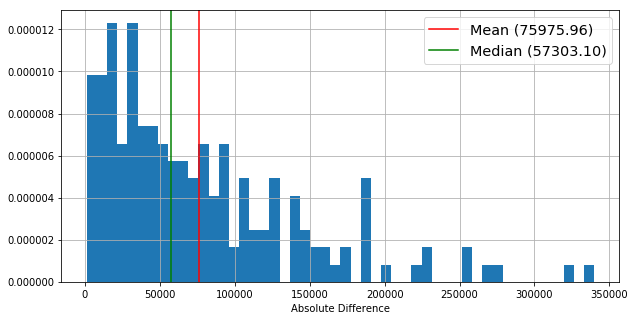

In [19]:
# Choosing the model
RFRcols = RandomForestRegressor(n_estimators=86, max_depth=380, n_jobs=9)

# Training the model
RFRcols.fit(train_data_ncols_features, train_data_ncols_labels)

# Evaluating the model
predict_price_ncols = RFRcols.predict(validation_data_ncols_features)
predict_price_ncols = denormalized_results(scaler_cols, validation_data_ncols, predict_price_ncols)
predict_price_ncols.sort_values(['Id'], inplace=True)
display(predict_price_ncols[:5])

denormalized_validation = denormalized_results(scaler_cols, validation_data_ncols, validation_data_ncols_labels)
plot_absolute_difference(denormalized_validation['SalePrice'].values, predict_price_ncols['SalePrice'].values)
#return_results_as_csv(predict_price_ncols, 'RandomForest')

<div class="alert alert-block alert-success">
    <h4>What is the model's complexity?</h4>
    We can see on <a href="https://www.quora.com/What-is-the-time-complexity-of-a-Random-Forest-both-building-the-model-and-classification">this link</a> that the complexity of such a model is $O\left(n_\text{trees}\,d\,\log(d)\right)$, with $d$ being the depth of the tree. Thus, as we took relatively low number of estimators and depth value, the model is quite fast to predict prices.
</div>

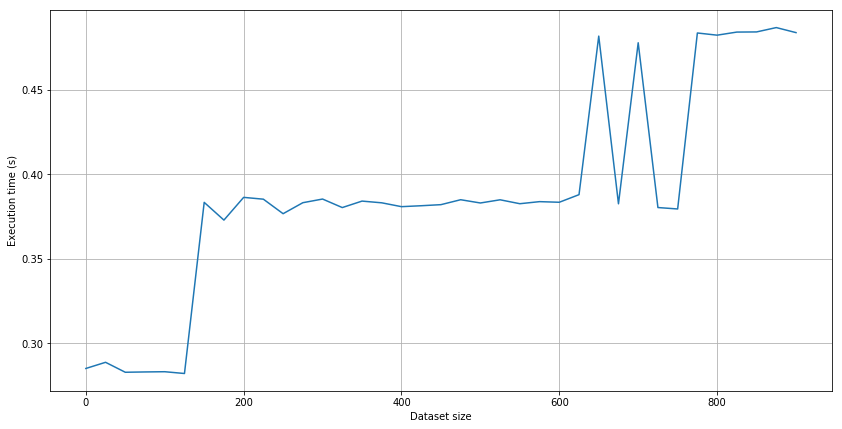

In [20]:
time_model(RFRcols, train_data_ncols_features, train_data_ncols_labels)

<div class="alert alert-block alert-success">
    We can see on this graph that the server being highly requested as we are making our computations, we are able to see the most little variations in the CPU performance. It implies that, as we can see on the graph, the execution time is really short.
</div>

<div class="alert alert-block alert-success">
    <h4>Is the model interpretable?</h4>
    This model is not interpretable. Indeed, it performs by averaging a lot of overfitted estimators which do not have that much sense in themselves.
</div>

<div class="alert alert-block alert-success">
    <h3>Model 2 - Decison Trees</h3>
</div>

In [21]:
from sklearn.tree import DecisionTreeRegressor

# Defining hyperparameters possible values
hyperparameters = {
    'max_depth': list(range(1, 2000))
}

parameter_grid = list(ParameterGrid(hyperparameters))
resultsDF_rows = pd.DataFrame(columns=['max_depth' ,'loss'])
resultsDF_cols = pd.DataFrame(columns=['max_depth', 'loss'])

verbose = False
i = 1
starting_time = time()
last_printed = 0

for parameter_combination in parameter_grid:
    # Defining the models
    DTRrows = DecisionTreeRegressor(max_depth=parameter_combination['max_depth'])
    DTRcols = DecisionTreeRegressor(max_depth=parameter_combination['max_depth'])
    
    # Training the models
    DTRrows.fit(train_data_nrows_features, train_data_nrows_labels)
    DTRcols.fit(train_data_ncols_features, train_data_ncols_labels)
    
    # Computing losses
    parameter_combination['loss'] = mse(scaler_rows, DTRrows.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, DTRcols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
    
print("It took {0} seconds to get these results.".format(int((time() - starting_time))))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

It took 99 seconds to get these results.


,max_depth,loss
1060,1061.0,0.038531
381,382.0,0.038846
23,24.0,0.039244
104,105.0,0.039348
142,143.0,0.039599


,max_depth,loss
132,133.0,0.035843
508,509.0,0.035852
762,763.0,0.035894
1671,1672.0,0.036015
151,152.0,0.036300


,Id,SalePrice
108,7.0,254556.642857
136,20.0,141635.426829
74,28.0,316214.354839
156,42.0,141635.426829
113,48.0,231699.571429


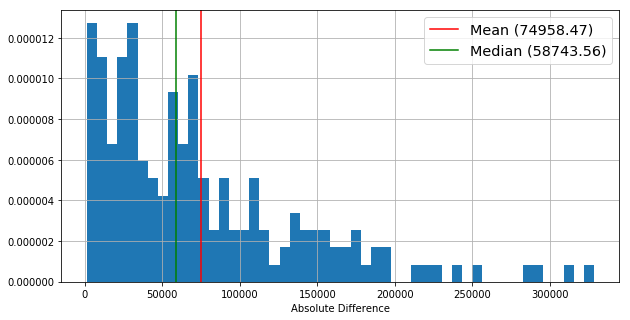

In [22]:
# Choosing the model
DTRcols = DecisionTreeRegressor(max_depth=5)

# Training the model
DTRcols.fit(train_data_ncols_features, train_data_ncols_labels)

# Evaluating the model
predict_price_ncols = DTRcols.predict(validation_data_ncols_features)
predict_price_ncols = denormalized_results(scaler_cols, validation_data_ncols, predict_price_ncols)
predict_price_ncols.sort_values(['Id'], inplace=True)
display(predict_price_ncols[:5])

return_results_as_csv(predict_price_ncols, 'DecisionTree')
denormalized_validation = denormalized_results(scaler_cols, validation_data_ncols, validation_data_ncols_labels)
plot_absolute_difference(denormalized_validation['SalePrice'].values, predict_price_ncols['SalePrice'].values)

<div class="alert alert-block alert-success">
    <h4>What is the model's complexity?</h4>
</div>

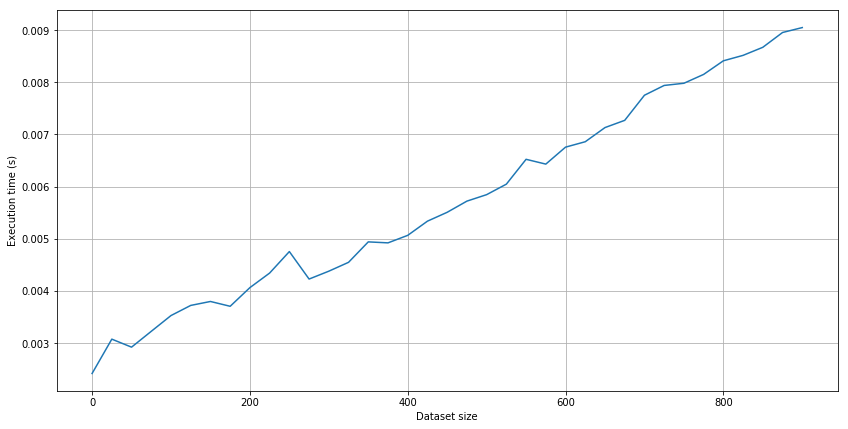

In [23]:
time_model(DTRcols, train_data_ncols_features, train_data_ncols_labels)

<div class="alert alert-block alert-success">
    <h4>Is the model interpretable?</h4>
    Yes, it is one of the main interest of the Decision Trees. We could draw the Tree to explicitely see how the model makes predictions, so that we can do one by hand.
</div>

<div class="alert alert-block alert-success">
    <h3>Model 3 - Neural Network</h3>
</div>

In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
from time import time
import warnings
from sklearn.exceptions import ConvergenceWarning

In [25]:
warnings.filterwarnings('ignore')

# Defining hyperparameters possible values
hyperparameters = {
    'alpha': [1e-6, 1e-4, 1e-2],
    'learning_rate_init': [1e-6, 1e-4, 1e-2],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [tuple([100] * i) for i in [1, 5, 10, 100]]
}

parameter_grid = list(ParameterGrid(hyperparameters))
resultsDF_rows = pd.DataFrame(columns=['alpha', 'learning_rate_init', 'learning_rate', 'solver', 'hidden_layer_sizes', 'loss'])
resultsDF_cols = pd.DataFrame(columns=['alpha', 'learning_rate_init', 'learning_rate', 'solver', 'hidden_layer_sizes', 'loss'])

verbose = False
i = 1

starting_time = time()
last_printed = 0

for parameter_combination in parameter_grid:
    # Defining the models
    regressor = MLPRegressor(
        hidden_layer_sizes=parameter_combination['hidden_layer_sizes'],
        early_stopping=True,
        learning_rate_init=parameter_combination['learning_rate_init'],
        learning_rate=parameter_combination['learning_rate'],
        alpha=parameter_combination['alpha'],
        solver=parameter_combination['solver'],
        max_iter=200
    )
    regressor_cols = MLPRegressor(
        hidden_layer_sizes=parameter_combination['hidden_layer_sizes'],
        early_stopping=True,
        learning_rate_init=parameter_combination['learning_rate_init'],
        learning_rate=parameter_combination['learning_rate'],
        alpha=parameter_combination['alpha'],
        solver=parameter_combination['solver'],
        max_iter=200
    )
    
    # Training  the models
    regressor.fit(train_data_nrows_features, train_data_nrows_labels)
    regressor_cols.fit(train_data_ncols_features, train_data_ncols_labels)
    
    # Computing losses
    parameter_combination['loss'] = mse(scaler_rows, regressor.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, regressor_cols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
print("It took {0} minutes to get these results.".format(int((time() - starting_time)) // 60))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

It took 131 minutes to get these results.


,alpha,learning_rate_init,learning_rate,solver,hidden_layer_sizes,loss
282,0.010000,0.0001,invscaling,lbfgs,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.014669
179,0.000100,0.0100,invscaling,adam,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.015298
170,0.000100,0.0100,constant,adam,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.015950
62,0.000001,0.0100,constant,adam,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.016260
165,0.000100,0.0001,constant,lbfgs,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.016483


,alpha,learning_rate_init,learning_rate,solver,hidden_layer_sizes,loss
269,0.010000,0.0100,adaptive,adam,"(100, 100, 100, 100, 100)",0.017039
53,0.000001,0.0100,adaptive,adam,"(100, 100, 100, 100, 100)",0.018023
66,0.000001,0.0001,invscaling,lbfgs,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.018306
183,0.000100,0.0001,adaptive,lbfgs,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.018903
296,0.010000,0.0100,adaptive,adam,"(100, 100, 100, 100, 100, 100, 100, 100, 100, ...",0.018985


In [26]:
[len(tuple) for tuple in resultsDF_rows.sort_values('loss')['hidden_layer_sizes'].values][:20]

[10, 10, 10, 10, 10, 5, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 10, 10, 5, 10]

<div class="alert alert-block alert-success">
    Interestingly enough, we can see that the models that perform well are not the deeper ones. It is surely due to the fact that deeper model are most-likely to overfit the data. Still, we can see that we can exclude some values from our parameters for further testing:
    <ul>
        <li> the $svg$ optimizer and, for the sake of computation speed, the $adam$ one </li>
        <li> the $10^{-6}$ value for $learning\_rate\_init$ </li>
        <li> the $1$ and $100$ sizes for the number of hidden layers and, for the sake of computation speed, the $5$ one </li>
        <li> the $10^{-6}$ value for $alpha$ </li>
    </ul>

We will, for the sake of computation speed, make the assumption that, as the two datasets are quite similar, we can also remove these values for the dataset from which we removed some columns. We also have to note that the models which perform the best do not reach the maximum number of iteration, as we can see with the column ```ConvergenceWarning```.
</div>

In [ ]:
learning_rates = ['constant', 'invscaling', 'adaptive']

# Defining hyperparameters statistical laws
hyperparameters = {
    'alpha': scipy.stats.uniform(1e-4, 1e-2),
    'learning_rate_init': scipy.stats.uniform(1e-4, 1e-2),
    'learning_rate': scipy.stats.randint(0, 3),
    'hidden_layer_sizes': scipy.stats.randint(5, 21),
}

parameter_grid = list(ParameterSampler(hyperparameters, n_iter=50))

verbose = False
i = 1

starting_time = time()
last_printed = 0
resultsDF_rows = pd.DataFrame(columns=['alpha', 'learning_rate_init', 'learning_rate', 'solver', 'hidden_layer_sizes', 'loss'])
resultsDF_cols = pd.DataFrame(columns=['alpha', 'learning_rate_init', 'learning_rate', 'solver', 'hidden_layer_sizes', 'loss'])


for parameter_combination in parameter_grid:
    parameter_combination['hidden_layer_sizes'] = tuple([100] * parameter_combination['hidden_layer_sizes'])
    
    # Defining the models
    regressor = MLPRegressor(
        hidden_layer_sizes=parameter_combination['hidden_layer_sizes'],
        early_stopping=True,
        learning_rate_init=parameter_combination['learning_rate_init'],
        learning_rate=learning_rates[parameter_combination['learning_rate']],
        alpha=parameter_combination['alpha'],
        solver='lbfgs',
        max_iter=200
    )
    regressor_cols = MLPRegressor(
        hidden_layer_sizes=parameter_combination['hidden_layer_sizes'],
        early_stopping=True,
        learning_rate_init=parameter_combination['learning_rate_init'],
        learning_rate=learning_rates[parameter_combination['learning_rate']],
        alpha=parameter_combination['alpha'],
        solver='lbfgs',
        max_iter=200
    )
    
    # Training the models
    regressor.fit(train_data_nrows_features, train_data_nrows_labels)
    regressor_cols.fit(train_data_ncols_features, train_data_ncols_labels)
    
    parameter_combination['solver'] = 'lbfgs'
    
    # Computing losses
    parameter_combination['loss'] = mse(scaler_rows, regressor.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, regressor_cols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
print("It took {0} minutes to get these results.".format(int((time() - starting_time)) // 60))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

In [61]:
# Choosing the model
regressor = MLPRegressor(
        hidden_layer_sizes=(100,),
        early_stopping=True,
        learning_rate_init=1e-4,
        learning_rate='constant',
        alpha=1e-4,
        solver='lbfgs',
        max_iter=200
    )

# Training the model
regressor.fit(train_data_nrows_features, train_data_nrows_labels)

# Evaluating the model
results = denormalized_results(scaler_rows, validation_data_nrows, regressor.predict(validation_data_nrows_features))
results.sort_values(['Id'],inplace=True)
display(results[:10])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.0001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

<div class="alert alert-block alert-success">
    <h4>What is the model's complexity?</h4>
    The complexity of a full-connected NeuralNetwork like this is at least $O\left(n^3\,m\right)$ where $n$ is the mean height of an hidden layer and $m$ the depth of the network.
</div>

In [ ]:
time_model()

<div class="alert alert-block alert-success">
    <h4>Is the model interpretable?</h4>
    The model is not interpretable. That's one of the main drawbacks of Neural Networks: in contrary to Decision Trees, we cannot see how the model behaves just by looking at it, which is even more true for deep and wide Neural Networks, like the ones we built there.
</div>

<div class="alert alert-block alert-success">
    <h3>Model 4 - LASSO</h3>
</div>

In [25]:
from sklearn.linear_model import Lasso

# Defining hyperparameters possible values
hyperparameters = {
    'alpha': list(np.linspace(1e-4, 1e-2, 1000))
}

parameter_grid = list(ParameterGrid(hyperparameters))
resultsDF_rows = pd.DataFrame(columns=['alpha' ,'loss'])
resultsDF_cols = pd.DataFrame(columns=['alpha', 'loss'])

verbose = False
i = 1
starting_time = time()
last_printed = 0

for parameter_combination in parameter_grid:
    # Defining the models
    LASSOrows = Lasso(alpha=parameter_combination['alpha'])
    LASSOcols = Lasso(alpha=parameter_combination['alpha'])
    
    # Training the models
    LASSOrows.fit(train_data_nrows_features, train_data_nrows_labels)
    LASSOcols.fit(train_data_ncols_features, train_data_ncols_labels)
    
    # Computing losses
    parameter_combination['loss'] = mse(scaler_rows, LASSOrows.predict(validation_data_nrows_features), validation_data_nrows_labels)
    resultsDF_rows = resultsDF_rows.append(parameter_combination, ignore_index=True)
    
    parameter_combination['loss'] = mse(scaler_cols, LASSOcols.predict(validation_data_ncols_features), validation_data_ncols_labels)
    resultsDF_cols = resultsDF_cols.append(parameter_combination, ignore_index=True)

    if verbose:
        to_print = int(100 * i / len(parameter_grid))
        if to_print != last_printed:
            print("Advancement: {0} %".format(to_print))
            last_printed = to_print
    
    i += 1
    
print("It took {0} seconds to get these results.".format(int((time() - starting_time))))
display(resultsDF_rows.sort_values('loss')[:5])
display(resultsDF_cols.sort_values('loss')[:5])

It took 270 seconds to get these results.


,alpha,loss
569,0.005739,0.014923
575,0.005798,0.014923
570,0.005749,0.014923
571,0.005759,0.014923
572,0.005768,0.014923


,alpha,loss
559,0.005640,0.021052
558,0.005630,0.021052
560,0.005650,0.021052
561,0.005659,0.021052
557,0.005620,0.021052


,Id,SalePrice
76,7.0,283525.670617
96,20.0,123764.650674
53,28.0,297190.334365
112,42.0,179778.444726
80,48.0,247925.104739


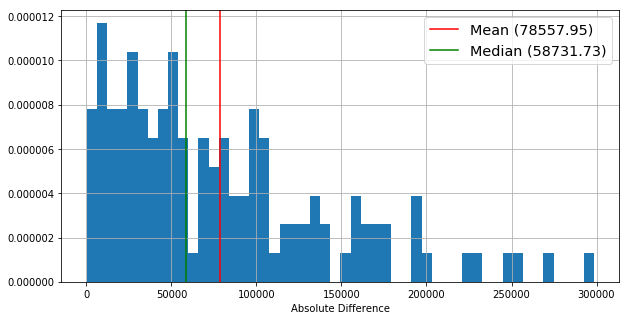

In [83]:
# Choosing model
LASSOrows = Lasso(alpha=0.005739)

# Training model
LASSOrows.fit(train_data_nrows_features, train_data_nrows_labels)

# Evaluating model
predict_price_nrows = LASSOrows.predict(validation_data_nrows_features)
predict_price_nrows = denormalized_results(scaler_rows, validation_data_nrows, predict_price_nrows)
predict_price_nrows.sort_values(['Id'], inplace=True)
display(predict_price_nrows[:5])

denormalized_validation = denormalized_results(scaler_rows, validation_data_nrows, validation_data_nrows_labels)
plot_absolute_difference(denormalized_validation['SalePrice'].values, predict_price_nrows['SalePrice'].values)

<div class="alert alert-block alert-success">
    <h4>What is the model's complexity?</h4>
    We can see on <a href="https://www.quora.com/What-is-the-time-complexity-of-a-Random-Forest-both-building-the-model-and-classification">this link</a> that the complexity of such a model is $O\left(n_\text{trees}\,d\,\log(d)\right)$, with $d$ being the depth of the tree. Thus, as we took relatively low number of estimators and depth value, the model is quite fast to predict prices.
</div>

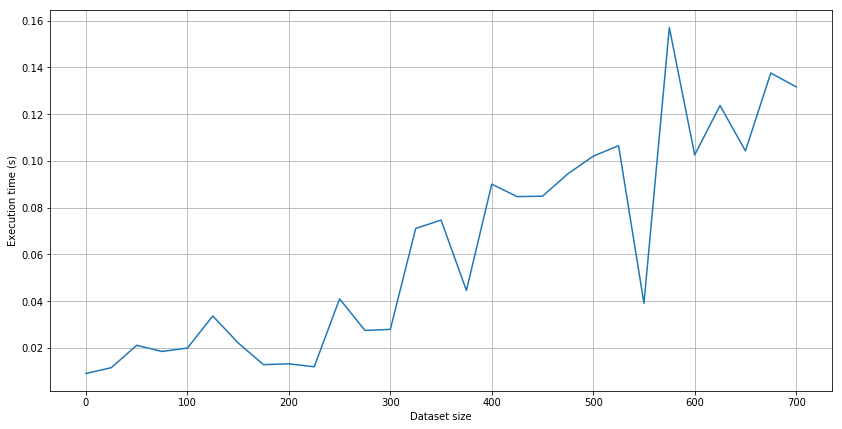

In [17]:
time_model(LASSOrows, train_data_nrows_features, train_data_nrows_labels)

<div class="alert alert-block alert-success">
    We can see on this graph that the server being highly requested as we are making our computations, we are able to see the most little variations in the CPU performance. It implies that, as we can see on the graph, the execution time is really short.
</div>

<div class="alert alert-block alert-success">
    <h4>Is the model interpretable?</h4>
    This model is not interpretable. Indeed, it performs by averaging a lot of overfitted estimators which do not have that much sense in themselves.
</div>

<div class="alert alert-block alert-success">
    <h3>4. Conclusion</h3>
    The <b>lowest loss</b> we were able to find was by using the <b>Lasso regressor</b>. Thus, it is the one we used to generate our .csv submission file.
</div>

,Id,SalePrice
0,1207.0,72259.099438
1,1208.0,204698.303379
2,1209.0,133143.951338
3,1210.0,208066.479113
4,1211.0,144491.956945


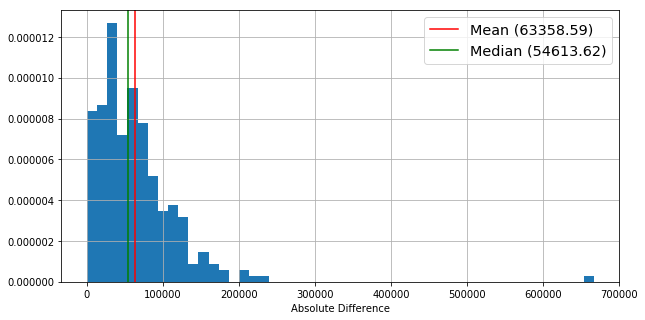

In [84]:
predict_price_nrows = LASSOrows.predict(test_data_nrows_features)
predict_price_nrows = denormalized_results(scaler_rows_test, test_data_nrows, predict_price_nrows)
predict_price_nrows.sort_values(['Id'], inplace=True)
display(predict_price_nrows[:5])
return_results_as_csv(predict_price_nrows, 'Final')

denormalized_validation = denormalized_results(scaler_rows_test, test_data_nrows, test_data_nrows_labels)
plot_absolute_difference(denormalized_validation['SalePrice'].values, predict_price_nrows['SalePrice'].values)

<div class="">
    <h2>Submission Instructions</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;" />    
</div>

- The goal of this challenge is to construct a model for predicting house prices;
<br><br>

- Your submission will have two components:

    1. An <b>HTML version of your notebook</b> exploring the various modelling aspects described above;
    2. A CSV file containing your <b>final model's predictions on the given test data</b>. 
       This file should contain a header and have the following format:
       
        ```
        Id,SalePrice
        1461,169000.1
        1462,187724.1233
        1463,175221
        etc.
        ```
        
        An example submission file has been provided in the data directory of the repository.
        A leaderboard for this challenge will be ranked using the root mean squared error between the logarithm of the predicted value and the logarithm of the observed sales price. 
        Taking logs ensures that errors in predicting expensive houses and cheap houses will have a similar impact on the overall result;
<br><br>
- This exercise is due on <b>04/04/2019</b>.

<div class="">
    <h2>Dataset Description</h2>
    <hr style="height:1px;border:none;color:#333;background-color:#333;"/>    
</div>

#### * Files

* train.csv - The training dataset;
* test.csv - The test dataset;
* data_description.txt - Full description of each column.

#### * Attributes

A brief outline of the available attributes is given below:

* <i>SalePrice</i>: The property's sale price in dollars. This is the target variable that your model is intended to predict;

* <i>MSSubClass</i>: The building class;
* <i>MSZoning</i>: The general zoning classification;
* <i>LotFrontage</i>: Linear feet of street connected to property;
* <i>LotArea</i>: Lot size in square feet;
* <i>Street</i>: Type of road access;
* <i>Alley</i>: Type of alley access;
* <i>LotShape</i>: General shape of property;
* <i>LandContour</i>: Flatness of the property;
* <i>Utilities</i>: Type of utilities available;
* <i>LotConfig</i>: Lot configuration;
* <i>LandSlope</i>: Slope of property;
* <i>Neighborhood</i>: Physical locations within Ames city limits;
* <i>Condition1</i>: Proximity to main road or railroad;
* <i>Condition2</i>: Proximity to main road or railroad (if a second is present);
* <i>BldgType</i>: Type of dwelling;
* <i>HouseStyle</i>: Style of dwelling;
* <i>OverallQual</i>: Overall material and finish quality;
* <i>OverallCond</i>: Overall condition rating;
* <i>YearBuilt</i>: Original construction date;
* <i>YearRemodAdd</i>: Remodel date;
* <i>RoofStyle</i>: Type of roof;
* <i>RoofMatl</i>: Roof material;
* <i>Exterior1st</i>: Exterior covering on house;
* <i>Exterior2nd</i>: Exterior covering on house (if more than one material);
* <i>MasVnrType</i>: Masonry veneer type;
* <i>MasVnrArea</i>: Masonry veneer area in square feet;
* <i>ExterQualv</i>: Exterior material quality;
* <i>ExterCond</i>: Present condition of the material on the exterior;
* <i>Foundation</i>: Type of foundation;
* <i>BsmtQual</i>: Height of the basement;
* <i>BsmtCond</i>: General condition of the basement;
* <i>BsmtExposure</i>: Walkout or garden level basement walls;
* <i>BsmtFinType1</i>: Quality of basement finished area;
* <i>BsmtFinSF1</i>: Type 1 finished square feet;
* <i>BsmtFinType2</i>: Quality of second finished area (if present);
* <i>BsmtFinSF2</i>: Type 2 finished square feet;
* <i>BsmtUnfSF</i>: Unfinished square feet of basement area;
* <i>TotalBsmtSF</i>: Total square feet of basement area;
* <i>Heating</i>: Type of heating;
* <i>HeatingQC</i>: Heating quality and condition;
* <i>CentralAir</i>: Central air conditioning;
* <i>Electrical</i>: Electrical system;
* <i>1stFlrSF</i>: First Floor square feet;
* <i>2ndFlrSF</i>: Second floor square feet;
* <i>LowQualFinSF</i>: Low quality finished square feet (all floors);
* <i>GrLivArea</i>: Above grade (ground) living area square feet;
* <i>BsmtFullBath</i>: Basement full bathrooms;
* <i>BsmtHalfBath</i>: Basement half bathrooms;
* <i>FullBath</i>: Full bathrooms above grade;
* <i>HalfBath</i>: Half baths above grade;
* <i>Bedroom</i>: Number of bedrooms above basement level;
* <i>Kitchen</i>: Number of kitchens;
* <i>KitchenQual</i>: Kitchen quality;
* <i>TotRmsAbvGrd</i>: Total rooms above grade (does not include bathrooms);
* <i>Functional</i>: Home functionality rating;
* <i>Fireplaces</i>: Number of fireplaces;
* <i>FireplaceQu</i>: Fireplace quality;
* <i>GarageType</i>: Garage location;
* <i>GarageYrBlt</i>: Year garage was built;
* <i>GarageFinish</i>: Interior finish of the garage;
* <i>GarageCars</i>: Size of garage in car capacity;
* <i>GarageArea</i>: Size of garage in square feet;
* <i>GarageQual</i>: Garage quality;
* <i>GarageCond</i>: Garage condition;
* <i>PavedDrive</i>: Paved driveway;
* <i>WoodDeckSF</i>: Wood deck area in square feet;
* <i>OpenPorchSF</i>: Open porch area in square feet;
* <i>EnclosedPorch</i>: Enclosed porch area in square feet;
* <i>3SsnPorch</i>: Three season porch area in square feet;
* <i>ScreenPorch</i>: Screen porch area in square feet;
* <i>PoolArea</i>: Pool area in square feet;
* <i>PoolQC</i>: Pool quality;
* <i>Fence</i>: Fence quality;
* <i>MiscFeature</i>: Miscellaneous feature not covered in other categories;
* <i>MiscVal</i>: Value (in dollars) of miscellaneous feature;
* <i>MoSold</i>: Month sold;
* <i>YrSold</i>: Year sold;
* <i>SaleType</i>: Type of sale;
* <i>SaleCondition</i>: Condition of sale.
